# Quantifying the Ade2 locus editing efficiency of the Eco1RT - Cas9 system

### Import packages

In [1]:
import sys,os, glob
import shutil

import matplotlib as plt
plt.rcParams['pdf.fonttype'] = 42

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns

from Bio import SeqIO
import fuzzysearch
import re
from collections import Counter, OrderedDict
from Bio.Seq import Seq

### load dataframe of sample ID and conditions 

In [2]:
samples = pd.read_excel("msSBK12_samples.xlsx")
samples

,sample_name,Index Plate,description
0,msSBK_12_01,A1,ySCL38 induced no donor
1,msSBK_12_02,A2,ySCL38 induced + recording_donorv2 short
2,msSBK_12_03,A3,ySCL38 induced + recording_donorv2 long
3,msSBK_12_04,A4,ySCL38 induced no donor 6h
4,msSBK_12_05,A5,ySCL38 induced + recording_donorv2 6h
...,...,...,...
91,msSBK_12_92,H8,ySCL23 galactose 48h R3
92,msSBK_12_93,H9,ySCL24 galactose 48h R3
93,msSBK_12_94,H10,ySCL25 galactose 48h R3
94,msSBK_12_95,H11,ySCL39 galactose 48h R3


### define env

In [3]:
run = "/Users/slopez/Dropbox (Gladstone)/Santi_L_docs/shipman/miseq/msSBK_12"
ref = "ADE2.fa"

In [4]:
ref = "../ADE2.fa"
print ("="*60)
for file in glob.glob("msSBK_12_*"):
    fn = file.split("_L001")[0]
    condition = samples["description"][samples["sample_name"]==fn].to_string(index=False)
    if "ySCL" in condition and "38" not in condition: 
        # filter for files pertaining to the Ade2 editing assay
        
        print (fn + " -- " + condition)
        os.chdir(file)
        r1 = glob.glob("*R1_001*")[0]
        print (r1)
        old_r1 = glob.glob("trimmed_*")[0]
        print ("\nremoving pre-existing trimmed files\n")
        os.remove(old_r1)

        
        print ("\ntrimming files\n")
        cmd = "sickle se -f {0} -t sanger \
                -o trimmed_R1.fastq".format(r1)
        os.system(cmd)    
        print ("="*60)

        os.chdir(run)
        
    else:
        shutil.rmtree(file, ignore_errors=True)


msSBK_12_66 --  ySCL40 raffinose 24h R2
msSBK-12-66_S66_L001_R1_001.fastq

removing pre-existing trimmed files


trimming files

msSBK_12_83 --  ySCL39 raffinose 24h R3
msSBK-12-83_S83_L001_R1_001.fastq.gz

removing pre-existing trimmed files


trimming files

msSBK_12_81 --  ySCL24 raffinose 24h R3
msSBK-12-81_S81_L001_R1_001.fastq.gz

removing pre-existing trimmed files


trimming files

msSBK_12_61 --  ySCL22 raffinose 24h R2
msSBK-12-61_S61_L001_R1_001.fastq.gz

removing pre-existing trimmed files


trimming files

msSBK_12_90 --  ySCL40 galactose 24h R3
msSBK-12-90_S90_L001_R1_001.fastq.gz

removing pre-existing trimmed files


trimming files

msSBK_12_87 --  ySCL24 galactose 24h R3
msSBK-12-87_S87_L001_R1_001.fastq.gz

removing pre-existing trimmed files


trimming files

msSBK_12_10 --  ySCL22 raffinose 24h R1
msSBK-12-10_S10_L001_R1_001.fastq.gz

removing pre-existing trimmed files


trimming files

msSBK_12_13 --  ySCL25 raffinose 24h R1
msSBK-12-13_S13_L001_R1_001.fastq.gz

r

### parse files and pull indel profile

In [5]:
# define genomic region of interest
Region_dict = {'ADE2': {'flanking': ['GGGAATTGCTTATTAACGAA','CACAACTCTGGACATTATAC'], 'wt_or_edited': ['ATTGCCCCAAGGCCT','ATTGCCTGAAGGCCT']}}

def extract_and_exact_match(sequence):
	left_flank = fuzzysearch.find_near_matches(Region_dict[edit_site]['flanking'][0],sequence,max_l_dist=0)
	right_flank = fuzzysearch.find_near_matches(Region_dict[edit_site]['flanking'][1],sequence,max_l_dist=0)
	if len(left_flank) == 1 and len(right_flank) == 1:
		region = sequence[left_flank[0].end:right_flank[0].start]
		if region == Region_dict[edit_site]['wt_or_edited'][0]:
			return ('wt', region)
		elif region == Region_dict[edit_site]['wt_or_edited'][1]:
			return ('edited', region)
		else: return ('undetermined_no_site_match', region)
	else: return ('undetermined_no_flanking_match', None)

In [6]:
os.chdir(run)

df_exact_files = pd.DataFrame(columns=["sample_name", "condition", "wt", "edited",
                                 "undetermined_no_flanking_match", 'undetermined_no_site_match',
                                 "total reads", "edited_percent"])
fastq_reads = "trimmed_R1.fastq"
edit_site = "ADE2"
print ("="*60)

non_precise_exact = []

for file in glob.glob("msSBK_12_*"):
    all_reads_str = []
    outcomes_dict = {'wt':0,
				 'edited':0,
				 'undetermined_no_flanking_match':0,
				 'undetermined_no_site_match':0}

    fn = file.split("_L001")[0]
    condition = samples["description"][samples["sample_name"]==fn].to_string(index=False)
    print (fn + " -- " + condition)
    os.chdir(file)
    
    filename = glob.glob("*.fastq.gz")
    
    for seq_record in SeqIO.parse(fastq_reads, "fastq"):
        all_reads_str.append(str(seq_record.seq))
    read_counter = Counter(all_reads_str)
    for read in read_counter:
        if extract_and_exact_match(read)[0]=='undetermined_no_site_match':
            non_precise_exact.append(extract_and_exact_match(read)[1])
        outcomes_dict[extract_and_exact_match(read)[0]] += read_counter[read] 
    edited_percent = (float(outcomes_dict['edited'])/float(outcomes_dict['edited']+outcomes_dict['wt']))*100

    
    print ('{0} percent edited ({1} edited/ {2} wt)'.format(edited_percent,outcomes_dict['edited'],outcomes_dict['wt']))
    print ('{0} do not contain clean flanking regions'.format(outcomes_dict['undetermined_no_flanking_match']))
    print ('{0} contain flanking regions, but not a clean target site match to edited or wt'.format(outcomes_dict['undetermined_no_site_match']))
    print ("parsing done.\n"+ "="*60 + "\n")
    
    df_exact_files = df_exact_files.append({"sample_name": fn, "condition": condition, 
                               "wt": outcomes_dict['wt'], "edited": outcomes_dict['edited'],
                                 "undetermined_no_flanking_match": outcomes_dict['undetermined_no_flanking_match'],
                                'undetermined_no_site_match': outcomes_dict['undetermined_no_site_match'],
                                 "total reads": outcomes_dict['wt'] + outcomes_dict["edited"] + outcomes_dict['undetermined_no_flanking_match'] + outcomes_dict['undetermined_no_site_match'],
                                "edited_percent": edited_percent}, ignore_index=True)
    os.chdir(run)

msSBK_12_66 --  ySCL40 raffinose 24h R2
0.030933894267949392 percent edited (10 edited/ 32317 wt)
625 do not contain clean flanking regions
315 contain flanking regions, but not a clean target site match to edited or wt
parsing done.

msSBK_12_83 --  ySCL39 raffinose 24h R3
0.012481901243197363 percent edited (5 edited/ 40053 wt)
722 do not contain clean flanking regions
366 contain flanking regions, but not a clean target site match to edited or wt
parsing done.

msSBK_12_81 --  ySCL24 raffinose 24h R3
0.00650131651659461 percent edited (2 edited/ 30761 wt)
573 do not contain clean flanking regions
253 contain flanking regions, but not a clean target site match to edited or wt
parsing done.

msSBK_12_61 --  ySCL22 raffinose 24h R2
0.015371313286578921 percent edited (8 edited/ 52037 wt)
1009 do not contain clean flanking regions
471 contain flanking regions, but not a clean target site match to edited or wt
parsing done.

msSBK_12_90 --  ySCL40 galactose 24h R3
30.172869063127134 perc

## Create a dataframe to store data for plotting

In [7]:
# allowing no mismatches in flanking region
df_exact_files[["placehold", "strain", "growth_condition","time", "biorep"]] = df_exact_files["condition"].str.split(" ", n=4, expand = True)
df_exact_files = df_exact_files.drop("placehold", axis=1)
df_exact_plot = df_exact_files[df_exact_files["growth_condition"]!="raffinose"]

# add genotype information about strains
d = {"ySCL22": "-", "ySCL23": "Cas9", "ySCL24": "Eco1RT",
    "ySCL25": "Eco1RT + Cas9 (wt Eco1 ncRNA)",
     "ySCL39": "Eco1RT + Cas9 (long primer Eco1 ncRNA)",
     "ySCL40": "Eco1RT + Cas9 (long primer Eco1 ncRNA)"}
df_exact_plot["genotype"] = df_exact_plot["strain"].map(d)

display(df_exact_plot.head())

,sample_name,condition,wt,edited,undetermined_no_flanking_match,undetermined_no_site_match,total reads,edited_percent,strain,growth_condition,time,biorep,genotype
4,msSBK_12_90,ySCL40 galactose 24h R3,19833,8570,494,420,29317,30.172869,ySCL40,galactose,24h,R3,Eco1RT + Cas9 (long primer Eco1 ncRNA)
5,msSBK_12_87,ySCL24 galactose 24h R3,26466,6,458,216,27146,0.022665,ySCL24,galactose,24h,R3,Eco1RT
8,msSBK_12_76,ySCL25 galactose 48h R2,24677,15337,857,969,41840,38.329085,ySCL25,galactose,48h,R2,Eco1RT + Cas9 (wt Eco1 ncRNA)
9,msSBK_12_96,ySCL40 galactose 48h R3,13367,21456,789,659,36271,61.614450,ySCL40,galactose,48h,R3,Eco1RT + Cas9 (long primer Eco1 ncRNA)
10,msSBK_12_92,ySCL23 galactose 48h R3,22367,38,517,616,23538,0.169605,ySCL23,galactose,48h,R3,Cas9


## Plot editing efficiency per strain and retron variant

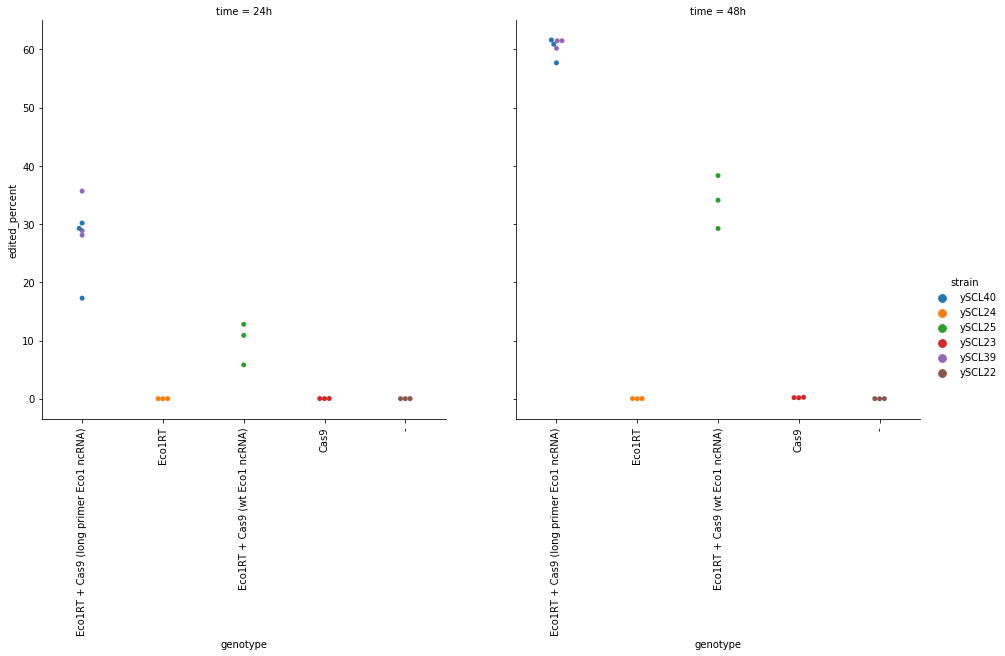

In [8]:
g = sns.catplot(x="genotype", y="edited_percent", col="time", hue = "strain",
                data=df_exact_plot, kind="swarm", height=6.27, aspect=6.7/6.27)
g.set_xticklabels(rotation=90)

g.savefig("crispey_stringent.png")


## Plot most frequent non-precise edits

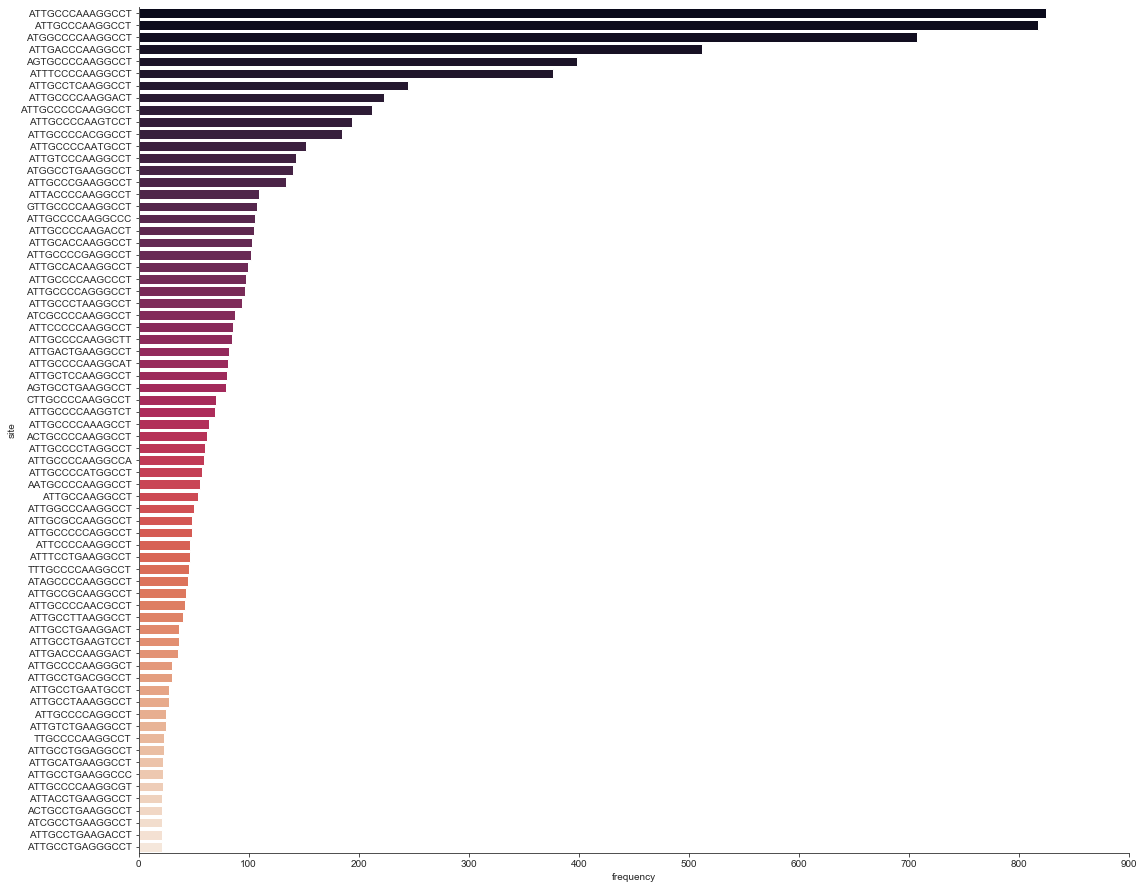

In [9]:
df_exact_plot["non_precise_edits_percent"]=df_exact_plot['undetermined_no_site_match']/df_exact_plot['total reads']*100

count_np_edits = Counter(non_precise_exact)
count_np_edits= OrderedDict(count_np_edits.most_common())
count_np_edits = {x: count for x, count in count_np_edits.items() if count > 20}

df_count_np_edits = pd.DataFrame.from_dict(data = count_np_edits, orient='index').reset_index()
df_count_np_edits = df_count_np_edits.rename(columns={"index": "site", 0: "frequency"})

sns.set_style("ticks")
g = sns.catplot(x="frequency", y="site",
                data=df_count_np_edits, kind="bar", height=12.27, aspect=15.7/12.27, 
                palette = "rocket", orient="h",
               )

g.set_xticklabels(rotation=0)
g.savefig("non-precise edits (stringent).pdf")

df_count_np_edits.to_csv("imprecisely edited sites.csv", sep = "\t")

In [10]:
display(df_exact_plot.head())


,sample_name,condition,wt,edited,undetermined_no_flanking_match,undetermined_no_site_match,total reads,edited_percent,strain,growth_condition,time,biorep,genotype,non_precise_edits_percent
4,msSBK_12_90,ySCL40 galactose 24h R3,19833,8570,494,420,29317,30.172869,ySCL40,galactose,24h,R3,Eco1RT + Cas9 (long primer Eco1 ncRNA),1.43262
5,msSBK_12_87,ySCL24 galactose 24h R3,26466,6,458,216,27146,0.022665,ySCL24,galactose,24h,R3,Eco1RT,0.795697
8,msSBK_12_76,ySCL25 galactose 48h R2,24677,15337,857,969,41840,38.329085,ySCL25,galactose,48h,R2,Eco1RT + Cas9 (wt Eco1 ncRNA),2.31597
9,msSBK_12_96,ySCL40 galactose 48h R3,13367,21456,789,659,36271,61.614450,ySCL40,galactose,48h,R3,Eco1RT + Cas9 (long primer Eco1 ncRNA),1.81688
10,msSBK_12_92,ySCL23 galactose 48h R3,22367,38,517,616,23538,0.169605,ySCL23,galactose,48h,R3,Cas9,2.61704


In [11]:
df_exact_plot.to_csv("crispey_all_data_miseq_stringent.csv", sep="\t")


## Plot the distribution of insertions, deletions, and transitions/transversions

,type of change,frequency
0,insertion,212
1,deletion,966
2,transition / transversion,7191


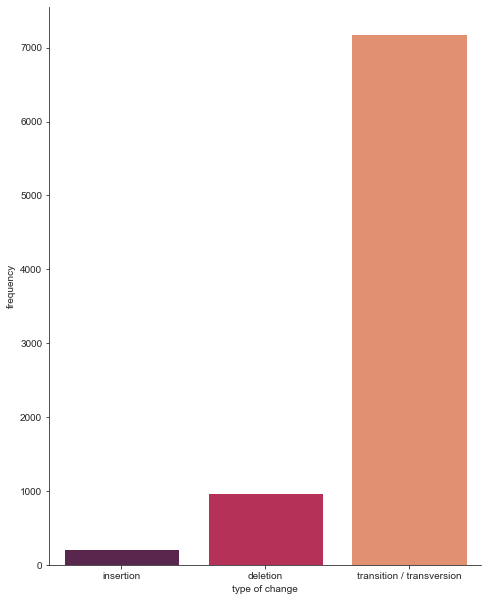

In [12]:
dict_indel = {"insertion": 0, "deletion": 0, "transition / transversion": 0} 
wt = "ATTGCCCCAAGGCCT"
for seq in count_np_edits:
    if len(seq)==len(wt):
        dict_indel["transition / transversion"] += count_np_edits[seq]
    elif len(seq)>len(wt):
        dict_indel["insertion"] += count_np_edits[seq]
    elif len(seq)<len(wt):
        dict_indel["deletion"] += count_np_edits[seq]

df_indel = pd.DataFrame.from_dict(data = dict_indel, orient='index').reset_index()
df_indel = df_indel.rename(columns={"index": "type of change", 0: "frequency"})
display(df_indel)

sns.set_style("ticks")

g = sns.catplot(x="type of change", y="frequency",
                data=df_indel, kind="bar", height=8.27, aspect=6.7/8.27, 
                palette = "rocket", orient="v",
               )

g.savefig("site change type and frequency.pdf")

df_indel.to_csv("site change type and frequency.csv", sep = "\t")
